In [1]:
import sys
sys.path.insert(0, "./efficientdet")
sys.path.insert(0, "./omegaconf")
sys.path.insert(0, "./wgf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from PIL import Image
import xml.etree.ElementTree as elemTree
from torchvision.transforms import functional as F


SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'


import numpy as np


def bb_intersection_over_union(A, B):
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()
    for t in range(len(boxes)):
        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            b = [int(label), float(score) * weights[t], float(box_part[0]), float(box_part[1]), float(box_part[2]), float(box_part[3])]
            
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse 
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box
    """

    box = np.zeros(6, dtype=np.float32)
    conf = 0
    conf_list = []
    for b in boxes:
        box[2:] += (b[1] * b[2:])
        conf += b[1]
        conf_list.append(b[1])
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[2:], new_box[2:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model 
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable  
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value
    :param allows_overflow: false if we want confidence score not exceed 1.0 
    
    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max']:
        print('Unknown conf_type: {}. Must be "avg" or "max"'.format(conf_type))
        exit()
    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []

        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())

        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            if not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(weights.sum(), len(new_boxes[i])) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(new_boxes[i]) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))

    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 2:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels

In [3]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(510, 510), height=540, width=960, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [4]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


class CustomDataset(object):
    def __init__(self, root, transforms, phase='train'):
        self.root = os.path.join(root, phase)
        self.transforms = transforms
        self.imgs = sorted(list(glob(self.root + '/*jpg') + list(glob(self.root + '/*png'))))
        self.labels = sorted(elemTree.parse(os.path.join(self.root, phase + '.xml')).findall('image'), key=lambda x: x.attrib['name'])
        self.phase = phase
        
    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = self.imgs[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
#         img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        boxes = []
        class_names = []
        class_num = {'bus' : 1, 'car' : 2, 'carrier' : 3, 'cat' : 4, 'dog' : 5, 'motorcycle' : 6, 'movable_signage' : 7,
                     'person' : 8, 'scooter' : 9, 'stroller' : 10, 'truck' : 11, 'wheelchair' : 12, 'barricade' : 13, 'bench' : 14, 'chair' : 15,
                     'fire_hydrant' : 16, 'kiosk': 17, 'parking_meter' : 18, 'pole': 19, 'potted_plant' : 20, 'power_controller' : 21, 'stop' : 22, 'table' : 23,
                     'traffic_light_controller':24, 'traffic_sign':25, 'tree_trunk':26, 'bollard':27, 'bicycle' : 28}
                     
        for box_info in label.findall('./box') :
            class_name,x1,y1,x2,y2 = box_info.attrib['label'],box_info.attrib['xtl'],box_info.attrib['ytl'],box_info.attrib['xbr'],box_info.attrib['ybr'] 
            x1,y1,x2,y2 = map(int,map(float, [x1,y1,x2,y2]))
            boxes.append([x1,y1,x2,y2])
            class_names.append(class_num[class_name])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        class_names = torch.as_tensor(class_names, dtype=torch.int64)

        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = boxes
        target["labels"] = class_names
        target["image_id"] = image_id
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': img,
                    'bboxes': target['boxes'],
                    'labels': class_names
                })
                if len(sample['bboxes']) > 0:
                    img = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        if self.phase == 'test':
            img = sample['image']
        
        
        return img, target, image_id

    def __len__(self):
        return len(self.imgs)

    def get_img_path(self, index) :
        return self.imgs[index]

# def get_transform(train):
#     transforms = []
#     transforms.append(ToTensor())
#     if train:
#         transforms.append(RandomHorizontalFlip(0.5))
#     return Compose(transforms)
                   
def collate_fn(batch):
    return tuple(zip(*batch))
                   
def data_loader(root, batch_size, phase='train') :
    is_train = False
    shuffle = False
    if phase == 'train' :
        is_train = True
        shuffle = True
    if phase == 'train':
        dataset = CustomDataset(root, get_train_transforms(), phase=phase)
    else:
        dataset = CustomDataset(root, get_valid_transforms(), phase=phase)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

    return dataloader

In [5]:
DATASET_PATH = f'../../../datasets/objstrgzip/07_object_detection/07_object_detection'
cuda = True
device = torch.device('cuda') if cuda else torch.device('cpu')

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
import gc

In [8]:
def load_ckpt_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 29
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_ckpt_net('./effdet5-cutmix-augmix/iter-checkpoint-1.3643243312835693loss-11000step.bin')

In [9]:
data_loader_val = data_loader(DATASET_PATH, 1, phase='val')
data_loader_test = data_loader(DATASET_PATH, 1, phase='test')        

In [10]:
def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            labels = det[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [prediction[image_index]['labels'].tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

[]


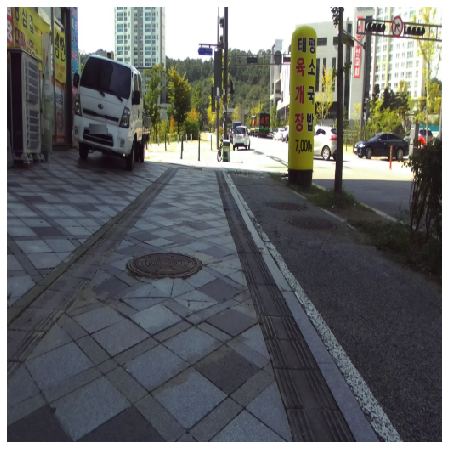

In [14]:
import matplotlib.pyplot as plt

for j, (images, _, image_ids) in enumerate(data_loader_test):
    if j == 97: break

predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=0.3)
boxes = boxes.astype(np.int32).clip(min=0, max=512)
print(boxes)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [11]:
from tqdm import tqdm

In [12]:
def make_folder(path) :
    try :
        os.mkdir(os.path.join(path))
    except :
        pass

def test(model, data_loader_test, device, prediction_dir) :
    class_name = {1 : 'bus', 2 : 'car', 3 :'carrier', 4 : 'cat', 5 : 'dog', 
                  6 : 'motorcycle', 7 : 'movable_signage', 8 : 'person', 9 : 'scooter', 10 : 'stroller', 
                  11 : 'truck', 12 : 'wheelchair', 13 : 'barricade', 14 : 'bench', 15 : 'chair',
                  16 : 'fire_hydrant', 17 : 'kiosk', 18 : 'parking_meter', 19 : 'pole', 20 : 'potted_plant', 
                  21 : 'power_controller', 22 : 'stop', 23 : 'table', 24 : 'traffic_light_controller', 
                  25 : 'traffic_sign', 26 : 'tree_trunk', 27 : 'bollard', 28 : 'bicycle'}
    model.to(device)
    model.eval()

    make_folder(prediction_dir)
    
    c_w = 960 / 512
    c_h = 540 / 512
    
    # 이미지 전체 반복
    pred_xml = elemTree.Element('predictions')
    pred_xml.text = '\n  '
    batch_size = data_loader_test.batch_size
    for idx, (images, _, image_ids) in tqdm(enumerate(data_loader_test)) :
        count = len(images)   
        
        i = 0
        predictions = make_predictions(images)
        boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=0.3)
        boxes = boxes.astype(np.int32).clip(min=0, max=512)

        texts = []
        # 이미지 한장에 대하여
        for n in range(count) :
                
            xml_image = elemTree.SubElement(pred_xml, 'image')
            
            img_name = data_loader_test.dataset.imgs[idx*batch_size+n].split('/')[-1].split('.png')[0]
            img_name = img_name.split('.jpg')[0]
            xml_image.attrib['name'] = img_name
            xml_image.text = '\n    '

            for index in range(len(boxes)) :
                box, label, score = boxes[index], int(labels[index]), scores[index]
                # class, score, x1, y1, x2, y2
                xml_predict = elemTree.SubElement(xml_image, 'predict')
                xml_predict.tail = '\n    '
                xml_predict.attrib['class_name'] = class_name[label]
                xml_predict.attrib['score'] = str(float(score))
                xml_predict.attrib['x1'] = str(int(box[0] * c_w))
                xml_predict.attrib['y1'] = str(int(box[1] * c_h))
                xml_predict.attrib['x2'] = str(int(box[2] * c_w))
                xml_predict.attrib['y2'] = str(int(box[3] * c_h))
                if index == len(boxes) - 1 :
                    xml_predict.tail = '\n  '
            xml_image.tail = '\n  '
            if idx == len(data_loader_test) - 1 and n == (count - 1):
                xml_image.tail = '\n'
    
    pred_xml = elemTree.ElementTree(pred_xml)
    pred_xml.write(prediction_dir + '/predictions.xml')

In [13]:
test(net, data_loader_test, device, './prediction')

17411it [29:50,  9.72it/s]


In [14]:
infer = elemTree.parse('./prediction/predictions.xml')

In [15]:
sample_image = infer.findall('image')[97]

In [16]:
BASE_DIR = f'../../../datasets/objstrgzip/07_object_detection/07_object_detection'
train_dir = f'{BASE_DIR}/train/'
val_dir = f'{BASE_DIR}/val/'
test_dir = f'{BASE_DIR}/test/'

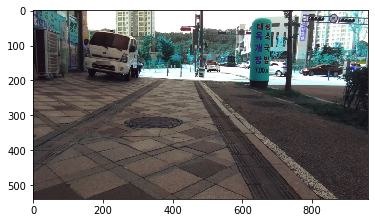

In [17]:
img = cv2.imread(os.path.join(test_dir, sample_image.attrib['name'])+'.png')
plt.imshow(img)
plt.show()

{'class_name': 'car', 'score': '0.621751070022583', 'x1': '667', 'x2': '733', 'y1': '147', 'y2': '187'}
{'class_name': 'car', 'score': '0.5846132636070251', 'x1': '778', 'x2': '898', 'y1': '153', 'y2': '189'}
{'class_name': 'car', 'score': '0.5411163568496704', 'x1': '138', 'x2': '318', 'y1': '64', 'y2': '208'}
{'class_name': 'truck', 'score': '0.41356131434440613', 'x1': '138', 'x2': '318', 'y1': '64', 'y2': '208'}
{'class_name': 'car', 'score': '0.3139941990375519', 'x1': '491', 'x2': '536', 'y1': '146', 'y2': '175'}


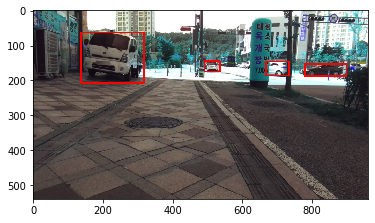

In [18]:
def change_type(x):
    return int(float(x))

for box in iter(sample_image.findall('predict')):
    print(box.attrib)
    x = (change_type(box.attrib['x1']), change_type(box.attrib['y1']))
    y = (change_type(box.attrib['x2']), change_type(box.attrib['y2']))
    cv2.rectangle(img, x, y, (255, 0, 0), 4)
plt.imshow(img)
plt.show()